# Histogram matching correction of hydroestimator data
This notebook aims at create a new dataset with corrected values from the hydroestimator data.

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

import xarray as xr

In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close()

In [3]:
regions = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [4]:
# Import hydroestimator data
he = xr.open_dataset(os.path.join(path_to_dataset,'HE','HE_gauges_hour.nc'))

In [5]:
# Perfor correction for each region
def correctHE(reg):
    j = regions.index[regions.region == reg].values
    
    regname = {'N':'NORTH', 'NE': 'NORTHEAST', 'S':'SOUTH', 'SE': 'SOUTHEAST', 'CW':'CENTRE-WEST'}

    hmfilename = 'Lookuptable-all-polygonclip-OCT-NOV-DEC-BRAZIL-'+regname[reg]+'.txt'
    hmfile = os.path.join(path_to_dataset,'HE','zlookuptables', hmfilename)
    hm = pd.DataFrame(np.loadtxt(hmfile, skiprows=1), columns=['standard', 'corrected'])
    
    selection = he.isel(location=j)
    corrected = np.interp(selection.HE_precip.values, hm.standard.values, hm.corrected.values)
    
    plt.plot(hm.standard, hm.corrected)
    
    return(j, corrected)

(738, 149)
(738, 95)
(738, 150)
(738, 100)
(738, 115)


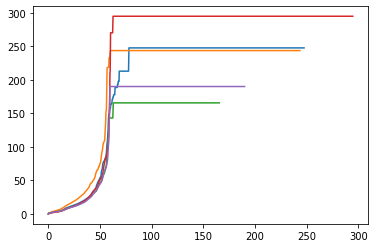

In [6]:
inds = []
corrected = []
for reg in {'N', 'NE', 'S', 'SE', 'CW'}:
    inds_reg, corrected_reg = correctHE(reg)
    print(corrected_reg.shape)
    inds.append(inds_reg)
    corrected.append(corrected_reg)

In [7]:
# Corrected dataset
corr = xr.Dataset(data_vars = {'HE_precip_corr': (["time", "location"], np.concatenate(corrected, axis=1))}, 
                coords=dict([("time", he.time), ("location", np.concatenate(inds))]))

In [8]:
corr = corr.sortby('location')

In [9]:
corr

<xarray.Dataset>
Dimensions:         (location: 609, time: 738)
Coordinates:
  * time            (time) datetime64[ns] 2020-12-01T01:00:00 ... 2020-12-31T...
  * location        (location) int64 0 1 2 3 4 5 6 ... 603 604 605 606 607 608
Data variables:
    HE_precip_corr  (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
he

<xarray.Dataset>
Dimensions:    (location: 609, time: 738)
Coordinates:
  * time       (time) datetime64[ns] 2020-12-01T01:00:00 ... 2020-12-31T18:00:00
  * location   (location) int64 0 1 2 3 4 5 6 7 ... 602 603 604 605 606 607 608
Data variables:
    HE_precip  (time, location) float64 ...

In [12]:
corr.to_netcdf(os.path.join(path_to_dataset,'HE','HE_gauges_hour_corrected.nc'))